# Análise de Comportamento de Bots Suspeitos

In [2]:
# dependências
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import community
import community as community_louvain
from collections import Counter

import os
os.chdir("..")

from util.load_graph import load_graph_by_edge, get_driver, get_user_property_keys, get_user_properties, get_property_values, get_property_values_for_users

In [3]:
driver = get_driver()

In [4]:
suspected_bots = pd.read_csv('../data/all_suspected_bots.csv')
suspected_bots

,user_id
0,284176a6c4724bfcc21e0bd37ebc80a4
1,c3725898c61e009376a1dc3caecb5a54
2,7a8c6f97bb725ae3efa6d5b06384debf
3,6af5166069b463db5980d6f68eaac7a5
4,7d004a92be94979b8a75e8df09af69b7
...,...
889,65a9d3ad87bfa33203b7246e8fa453a7
890,f21917b7e04dd74833ed4c2a6d3df774
891,abffd32c0730be5096ec18a5346411c5
892,39ee10516124280a22f1798f2a41f9a7


In [5]:
high_conf_suspected_bots = pd.read_csv('../data/highest_confident_bots.csv')
high_conf_suspected_bots

,user_id
0,9bc9ea4800037405bcdf572d68631bd3
1,b1004f1254518ccb2e5ea5b8dd49b473
2,db60a046ca125348b9cd4dda729b99ec
3,826c407c3fc0646f32523e05bd57b459
4,8d1a3c5b2ba0f29df8a6a5be0bb66191
5,036dd9c2c985d16f761e93ce7fe79919
6,26cd985388f2cf5c0b7918ec6fb6a87f
7,4d825174847c8e2d7db1c77a58e9b725


## Comparação Scores Gerais vs Suspeitos

In [6]:
def compare_property_averages(driver, suspected_bots_df, user_id_col='user_id'):
    sample_user = suspected_bots_df[user_id_col].iloc[0]
    properties = get_user_properties(driver, sample_user)

    results = []

    for prop, val in properties.items():
        if not isinstance(val, (int, float)):
            continue

        all_vals = get_property_values(driver, prop)
        susp_vals = get_property_values_for_users(
            driver, prop, suspected_bots_df[user_id_col]
        )

        if len(all_vals) == 0 or len(susp_vals) == 0:
            continue

        results.append({
            "property": prop,
            "avg_all_users": np.mean(all_vals),
            "avg_suspected_bots": np.mean(susp_vals),
            "ratio_susp_vs_all": np.mean(susp_vals) / np.mean(all_vals)
        })

    df = pd.DataFrame(results).sort_values(
        by="ratio_susp_vs_all", ascending=False
    )

    return df

In [7]:
compare_property_averages(driver, suspected_bots)

,property,avg_all_users,avg_suspected_bots,ratio_susp_vs_all
6,viral_score,0.006145,0.066683,10.851909
3,misinfo_score,0.132189,0.670096,5.069229
5,shares_score,0.522397,1.928357,3.691365
2,metronome_score,1.484604,1.504869,1.013650
0,content_originality,0.936023,0.776093,0.829138
4,network_diversity,0.557761,0.338266,0.606471
1,content_uniqueness,0.705840,0.292302,0.414120


In [8]:
compare_property_averages(driver, high_conf_suspected_bots)

,property,avg_all_users,avg_suspected_bots,ratio_susp_vs_all
3,misinfo_score,0.132189,1.537492,11.631015
5,shares_score,0.522397,2.771020,5.304435
2,metronome_score,1.484604,1.414798,0.952980
0,content_originality,0.936023,0.748413,0.799567
6,synchronicity_score,9.805440,6.314804,0.644010
4,network_diversity,0.557761,0.192369,0.344896
1,content_uniqueness,0.705840,0.083611,0.118456
7,viral_score,0.006145,0.000000,0.000000


# Encontrar subcomunidades

## Tipos de Similaridade e Arquétipos de Bots

### 1. SYNC_SIMILAR (Intensidade de Coordenação)

**O que mede:**  
Conecta bots que possuem um **Score de Sincronicidade** semelhante (relaciona quantos conteúdos compartilhados com quantos usuários).

**Arquétipos de bots identificados:**

- **Comunidade de alto score:** *Núcleo Central*.  
  Um grupo coeso de bots responsável pela explosão inicial e rápida de mensagens.

- **Comunidade de baixo score:** *Periferia*.  
  Bots que ficam para trás ou participam apenas de ondas menores e específicas.

---

### 2. METRONOME_SIMILAR (Impressão Digital Temporal)

**O que mede:**  
Conecta bots que compartilham o mesmo **Coeficiente de Variação** nos intervalos de postagem.

**Arquétipos de bots identificados:**

- **Comunidade A:** *Relógios*.  
  Bots com variância próxima de zero (extremamente robóticos).

- **Comunidade B:** *Mímicos*.  
  Bots configurados com um algoritmo específico de aleatorização para parecerem humanos (por exemplo, variância maior, porém idêntica entre si).

---

### 3. SHARES_SIMILAR (Perfil de Volume)

**O que mede:**  
Conecta bots com volume total de mensagens semelhante.

**Arquétipos de bots identificados:**

- **Comunidade de alto volume:** *Canhões de Spam*.  
  Projetados para inundar grupos.

- **Comunidade de baixo volume:** *Atiradores de Elite*.  
  Bots que postam raramente.

---

### 4. MISINFO_SIMILAR (Carga Útil: Desinformação)

**O que mede:**  
Conecta bots que dedicam uma proporção semelhante de sua atividade a mensagens com alto score de desinformação.

**Arquétipos de bots identificados:**

- **Comunidade de alto score:** *Especialistas em Desinformação*.  
  Contas criadas especificamente para espalhar narrativas direcionadas.

- **Comunidade de baixo score:** *Amplificadores Genéricos*.  
  Bots que amplificam conteúdo independentemente de sua veracidade.

---

### 5. VIRAL_SIMILAR (Carga Útil: Viralidade)

**O que mede:**  
Conecta bots com taxas de sucesso semelhantes na amplificação de conteúdo viral.

**Arquétipos de bots identificados:**

- **Comunidade de alto score:** *Amplificadores*.  
  Bots projetados para fazer conteúdos existentes virarem tendência.

- **Comunidade de baixo score:**  
  Bots que introduzem conteúdo que não se tornou viral.

---

### 6. CONTENT_ORIGINALITY_SIMILAR (Lógica de Repetição)

**O que mede:**  
Conecta bots com proporções semelhantes de **Textos Únicos / Total de Mensagens**.

**Arquétipos de bots identificados:**

- **Comunidade ~0.1 (Baixa):** *Drones de Copiar e Colar*.  
  Bots que encaminham exatamente o mesmo texto centenas de vezes.

- **Comunidade ~0.9 (Alta):** *Bots Generativos*.  
  Bots que alteram levemente o texto a cada postagem.

---

### 7. CONTENT_UNIQUENESS_SIMILAR (Efeito Câmara de Eco)

**O que mede:**  
Conecta bots com base no quão “mainstream” é o conteúdo que compartilham globalmente.

**Arquétipos de bots identificados:**

- **Comunidade de baixa singularidade:** *Câmara de Eco*.  
  Bots que compartilham apenas o que milhares de outras pessoas já estão compartilhando (reforço de consenso).

- **Comunidade de alta singularidade:** *Injetores*.  
  Bots que introduzem narrativas raras ou novas na rede.

---

### 8. NETWORK_DIVERSITY_SIMILAR (Estratégia de Implantação)

**O que mede:**  
Conecta bots com proporções semelhantes de **Grupos Únicos / Total de Parceiros**.

**Arquétipos de bots identificados:**

- **Comunidade de baixa diversidade:** *Bots Enxame*.  
  Conjunto de bots que atacam o mesmo pequeno grupo de comunidades, sobrecarregando um alvo específico.

- **Comunidade de alta diversidade:** *Bots Ponte*.  
  Bots que atuam como conectores, levando conteúdo de uma comunidade para outros grupos.


In [9]:
from statistics import mean, median

def add_group_score_stats(
    G,
    group_attr,
    score_attr,
    prefix=None,
    round_digits=4
):
    if prefix is None:
        prefix = group_attr

    group_scores = {}

    for node, data in G.nodes(data=True):
        group = data.get(group_attr)
        score = data.get(score_attr)

        if group is None or score is None:
            continue

        group_scores.setdefault(group, []).append(score)

    group_stats = {}
    for g, scores in group_scores.items():
        if len(scores) == 0:
            continue
        group_stats[g] = {
            'mean': round(mean(scores), round_digits),
            'median': round(median(scores), round_digits)
        }

    for node, data in G.nodes(data=True):
        group = data.get(group_attr)
        if group in group_stats:
            data[f'{prefix}_mean_{score_attr}'] = group_stats[group]['mean']
            data[f'{prefix}_median_{score_attr}'] = group_stats[group]['median']


In [ ]:
def classify_bot_behaviors(driver, suspected_bot_ids, output_dir='../data/visualization'):
    
    os.makedirs(output_dir, exist_ok=True)
    
    similarity_graphs = {
        'SYNC_SIMILAR': ('synchronicity_score', 'Coordenação'),
        'METRONOME_SIMILAR': ('metronome_score', 'Variação temporal'),
        'SHARES_SIMILAR': ('shares_score', 'Compartilhamento'),
        'MISINFO_SIMILAR': ('misinfo_score', 'Desinformação'),
        'VIRAL_SIMILAR': ('viral_score', 'Viral'),
        'CONTENT_ORIGINALITY_SIMILAR': ('content_originality', 'Originalidade do conteúdo'),
        'CONTENT_UNIQUENESS_SIMILAR': ('content_uniqueness', 'Singularidade do conteúdo'),
        'NETWORK_DIVERSITY_SIMILAR': ('network_diversity', 'Diversidade da rede')
    }
    
    bot_classifications = {}
    
    for graph_type, (score_name, behavior_name) in similarity_graphs.items():
        print(f"Processando {graph_type}...")
        G = load_graph_by_edge(driver, graph_type)
        
        suspected_nodes = [n for n in G.nodes() if n in suspected_bot_ids]
        G_bots = G.subgraph(suspected_nodes).copy()
        
        if len(G_bots.nodes()) < 2:
            print(f"Pulando {graph_type}: Menos que 2 nós")
            continue
        
        # CONNECTED COMPONENTS
        components = list(nx.connected_components(G_bots))
        print(f"Achou {len(components)} componentes conectados")

        for comp_id, comp in enumerate(components):
            subgraph = G_bots.subgraph(comp)
            density = nx.density(subgraph)
            avg_weight = (
                sum(d['weight'] for _, _, d in subgraph.edges(data=True)) /
                max(subgraph.number_of_edges(), 1)
            )

            for node in comp:
                G_bots.nodes[node]['component_id'] = comp_id
                G_bots.nodes[node]['component_size'] = len(comp)
                G_bots.nodes[node]['component_density'] = round(density, 4)
                G_bots.nodes[node]['component_avg_weight'] = round(avg_weight, 4)
                G_bots.nodes[node]['behavior_type'] = behavior_name
        
        # LOUVAIN
        partition = community_louvain.best_partition(
            G_bots,
            weight="weight",
            random_state=42
        )

        num_communities = len(set(partition.values()))
        print(f"Achou {num_communities} comunidades Louvain")

        community_sizes = Counter(partition.values())

        for node, comm_id in partition.items():
            G_bots.nodes[node]["louvain_community"] = comm_id
            G_bots.nodes[node]["louvain_community_size"] = community_sizes[comm_id]

            if node not in bot_classifications:
                bot_classifications[node] = {}
            bot_classifications[node][behavior_name] = comm_id

        # K-CORE
        try:
            core_numbers = nx.core_number(G_bots)
            for node, core in core_numbers.items():
                G_bots.nodes[node]['k_core'] = core
        except nx.NetworkXError:
            for node in G_bots.nodes():
                G_bots.nodes[node]['k_core'] = 0
        
        for node in G_bots.nodes():
            G_bots.nodes[node]['degree'] = G_bots.degree(node, weight='weight')

        add_group_score_stats(
            G_bots,
            group_attr='component_id',
            score_attr=score_name,
            prefix='component'
        )
        add_group_score_stats(
            G_bots,
            group_attr='louvain_community',
            score_attr=score_name,
            prefix='louvain'
        )
        
        gexf_filename = os.path.join(output_dir, f'{graph_type.lower()}_bot_communities.gexf')
        nx.write_gexf(G_bots, gexf_filename)
        print(f"  -> Salvou {gexf_filename}")
        print()
    
    if bot_classifications:
        df = pd.DataFrame.from_dict(bot_classifications, orient='index')
        df.index.name = 'user_id'
        df = df.reset_index()
        
        csv_filename = os.path.join(output_dir, 'bot_behavior_classifications.csv')
        df.to_csv(csv_filename, index=False)
        print(f"Salvo classificações {csv_filename}")
        
        return df
    else:
        return pd.DataFrame()

In [11]:
classify_bot_behaviors(driver, set(suspected_bots['user_id'].astype(str)))

Processando SYNC_SIMILAR...
Achou 18 componentes conectados
Achou 18 comunidades Louvain
  -> Salvou ../data/visualization/sync_similar_bot_communities.gexf

Processando METRONOME_SIMILAR...
Achou 7 componentes conectados
Achou 13 comunidades Louvain
  -> Salvou ../data/visualization/metronome_similar_bot_communities.gexf

Processando SHARES_SIMILAR...
Achou 8 componentes conectados
Achou 15 comunidades Louvain
  -> Salvou ../data/visualization/shares_similar_bot_communities.gexf

Processando MISINFO_SIMILAR...
Achou 8 componentes conectados
Achou 13 comunidades Louvain
  -> Salvou ../data/visualization/misinfo_similar_bot_communities.gexf

Processando VIRAL_SIMILAR...
Achou 2 componentes conectados
Achou 2 comunidades Louvain
  -> Salvou ../data/visualization/viral_similar_bot_communities.gexf

Processando CONTENT_ORIGINALITY_SIMILAR...
Achou 44 componentes conectados
Achou 44 comunidades Louvain
  -> Salvou ../data/visualization/content_originality_similar_bot_communities.gexf

Proce

,user_id,Coordenação,Variação temporal,Compartilhamento,Desinformação,Singularidade do conteúdo,Diversidade da rede,Originalidade do conteúdo,Viral
0,f233cf8b1d4ede06f32199a7e0081bf5,0.0,8.0,3.0,4.0,45.0,NaN,NaN,NaN
1,f79ecc500dbf58029a9731c669de0d6d,0.0,4.0,5.0,9.0,NaN,13.0,NaN,NaN
2,3e56c89adedd461832a4a3b4ab9b776a,1.0,0.0,5.0,8.0,52.0,5.0,24.0,NaN
3,82877970419bc104af73fe38cfb0de4c,1.0,8.0,8.0,NaN,NaN,2.0,NaN,NaN
4,d49f81df0c75d1d72bee6c5b2d707da0,1.0,0.0,3.0,NaN,63.0,6.0,16.0,NaN
...,...,...,...,...,...,...,...,...,...
889,8d5588a812455beddafec9db8dfb255a,NaN,NaN,2.0,NaN,57.0,3.0,NaN,NaN
890,668379871f925925b75be1d8aeed1a26,NaN,NaN,1.0,NaN,13.0,8.0,NaN,NaN
891,3505e2a48a426674e839996f69bb41ce,NaN,NaN,1.0,NaN,59.0,0.0,38.0,NaN
892,393f5b30052d2d5ab024de29fc45c7de,NaN,NaN,2.0,NaN,40.0,4.0,NaN,NaN


In [12]:
#classify_bot_behaviors(driver, set(high_conf_suspected_bots['user_id'].astype(str)))

## Categorização em arquétipos

In [13]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

similarity_graphs = {
    'SYNC_SIMILAR': ('synchronicity', 'Coordenação', 'synchronicity_score'),
    'METRONOME_SIMILAR': ('metronome', 'Variação temporal', 'metronome_score'),
    'SHARES_SIMILAR': ('shares', 'Volume de Compartilhamento', 'shares_score'),
    'MISINFO_SIMILAR': ('misinfo', 'Desinformação', 'misinfo_score'),
    'VIRAL_SIMILAR': ('viral', 'Viralidade', 'viral_score'),
    'CONTENT_UNIQUENESS_SIMILAR': ('content_uniqueness', 'Singularidade', 'content_uniqueness'),
    'NETWORK_DIVERSITY_SIMILAR': ('network_diversity', 'Diversidade de grupos', 'network_diversity'),
    'CONTENT_ORIGINALITY_SIMILAR': ('content_originality', 'Originalidade', 'content_originality')
}

def build_bot_archetypes(driver, suspected_bot_ids, similarity_graphs):
    print(f"--- Iniciando Mineração de {len(suspected_bot_ids)} suspeitos ---")
    
    user_features = {uid: {} for uid in suspected_bot_ids}
    
    for graph_type, (prefix, behavior_name, neo4j_prop) in similarity_graphs.items():
        print(f"Carregando grafo: {graph_type} ({behavior_name})...")
        
        G = load_graph_by_edge(driver, graph_type)
        
        relevant_nodes = [n for n in G.nodes() if n in suspected_bot_ids]
        G_sub = G.subgraph(relevant_nodes).copy()
        
        if len(G_sub) == 0:
            print(f"Nenhum bot suspeito encontrado na camada {graph_type}")
            for uid in suspected_bot_ids:
                user_features[uid][f'{prefix}_centrality'] = 0
                user_features[uid][f'{prefix}_density'] = 0
                user_features[uid][f'{prefix}_group_size'] = 0
                user_features[uid][f'{prefix}_score'] = 0
            continue

        # Calcula degree centrality
        centrality = nx.degree_centrality(G_sub)
        
        # Calcula densidade das componentes
        components = list(nx.connected_components(G_sub))
        node_density_map = {}
        node_size_map = {}
        for comp in components:
            comp_sub = G_sub.subgraph(comp)
            try:
                d = nx.density(comp_sub) 
            except:
                d = 0
            s = len(comp)
            for node in comp:
                node_density_map[node] = d
                node_size_map[node] = s
        
        # Mapeia features
        for uid in suspected_bot_ids:
            u_cent = 0
            u_dens = 0
            u_size = 0
            u_score = 0
            if uid in G_sub:
                u_cent = centrality.get(uid, 0)
                u_dens = node_density_map.get(uid, 0)
                u_size = node_size_map.get(uid, 0)
                
                u_score = G_sub.nodes[uid].get(neo4j_prop, 0)
                
            user_features[uid][f'{prefix}_centrality'] = u_cent
            user_features[uid][f'{prefix}_density'] = u_dens
            user_features[uid][f'{prefix}_group_size'] = u_size
            user_features[uid][f'{prefix}_score'] = u_score

    df = pd.DataFrame.from_dict(user_features, orient='index')
    return df.fillna(0)

In [14]:
def find_archetypes(df_features, n_clusters=4):
    print(f"Identificando {n_clusters} Arquétipos de Bots")
    
    # Normaliza dados
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_features), 
                             columns=df_features.columns, 
                             index=df_features.index)
    
    # Executa K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(df_scaled)
    
    df_features['Archetype_ID'] = clusters
    
    archetype_dna = df_features.groupby('Archetype_ID').mean()
    
    return df_features, archetype_dna

In [15]:
def visualize_archetypes(archetype_dna):
    plt.figure(figsize=(14, 8))
    
    scaler = MinMaxScaler()
    dna_scaled = pd.DataFrame(scaler.fit_transform(archetype_dna), 
                              columns=archetype_dna.columns, 
                              index=archetype_dna.index)
    
    sns.heatmap(dna_scaled.T, cmap='RdYlBu_r', annot=True, fmt=".2f", linewidths=.5)
    plt.title("DNA Comportamental dos Arquétipos de Bots", fontsize=16)
    plt.xlabel("ID do Arquétipo (Cluster)", fontsize=12)
    plt.ylabel("Características (Densidade/Centralidade)", fontsize=12)
    plt.tight_layout()
    plt.show()

--- Iniciando Mineração de 894 suspeitos ---
Carregando grafo: SYNC_SIMILAR (Coordenação)...
Carregando grafo: METRONOME_SIMILAR (Variação temporal)...
Carregando grafo: SHARES_SIMILAR (Volume de Compartilhamento)...
Carregando grafo: MISINFO_SIMILAR (Desinformação)...
Carregando grafo: VIRAL_SIMILAR (Viralidade)...
Carregando grafo: CONTENT_UNIQUENESS_SIMILAR (Singularidade)...
Carregando grafo: NETWORK_DIVERSITY_SIMILAR (Diversidade de grupos)...
Carregando grafo: CONTENT_ORIGINALITY_SIMILAR (Originalidade)...
Identificando 5 Arquétipos de Bots


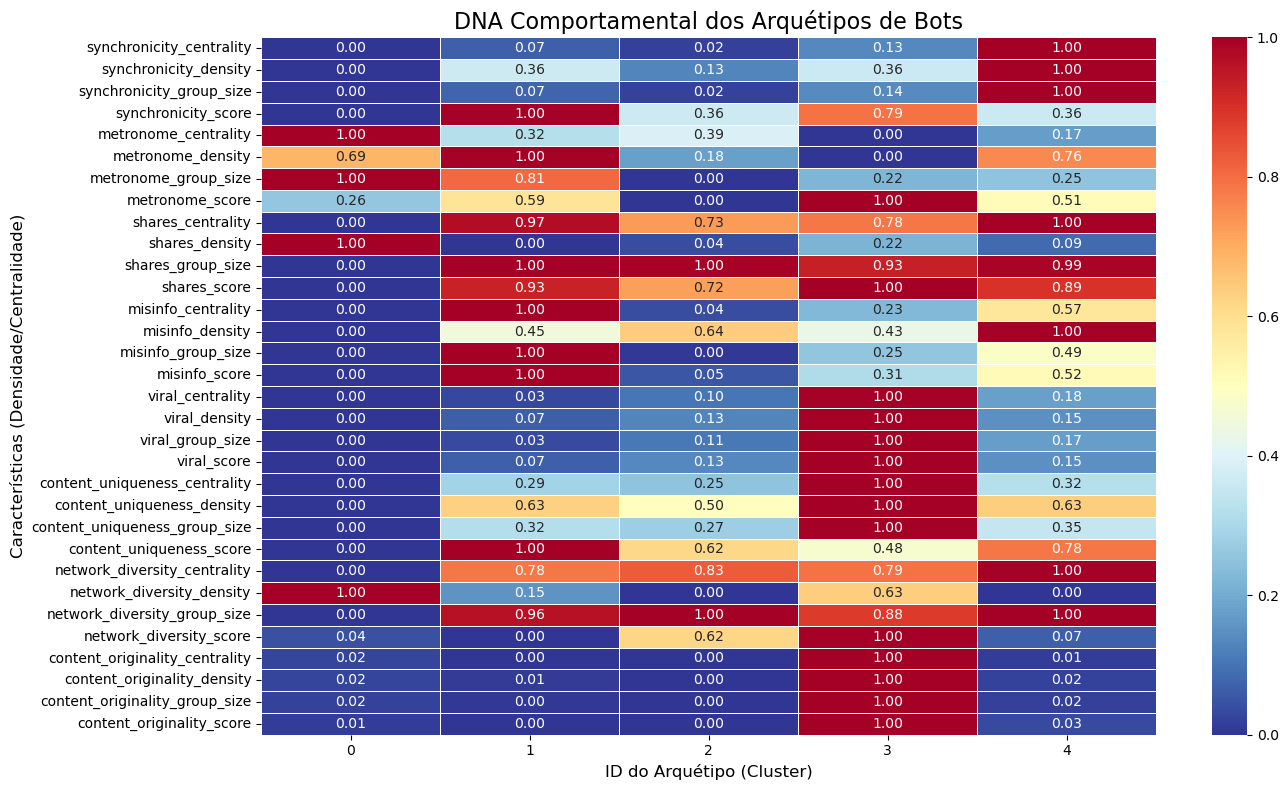

Análise concluída. Resultados salvos em 'bot_archetypes_final.csv'


In [16]:
suspected_bot_ids = set(suspected_bots['user_id'].astype(str))
df_bots = build_bot_archetypes(driver, suspected_bot_ids, similarity_graphs)

df_labeled, bot_dna = find_archetypes(df_bots, n_clusters=5)

visualize_archetypes(bot_dna)

df_labeled.to_csv("bot_archetypes_final.csv")
print("Análise concluída. Resultados salvos em 'bot_archetypes_final.csv'")

In [17]:
df_labeled

,synchronicity_centrality,synchronicity_density,synchronicity_group_size,synchronicity_score,metronome_centrality,metronome_density,metronome_group_size,metronome_score,shares_centrality,shares_density,...,content_uniqueness_score,network_diversity_centrality,network_diversity_density,network_diversity_group_size,network_diversity_score,content_originality_centrality,content_originality_density,content_originality_group_size,content_originality_score,Archetype_ID
b26f0c92a5d0db6d952517ce43625258,0.000000,0.000000,0,0.000000,0.093270,0.147625,819,1.686255,0.128852,0.102504,...,0.041009,0.044818,0.050737,654,0.309859,0.000000,0.0,1,0.393939,2
68315e81ed306141e9a20b4cea010f6e,0.000000,0.000000,0,0.000000,0.205431,0.147625,819,1.287204,0.000000,0.000000,...,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0,0.000000,0
48b1650017106d0218a958129c2e6547,0.091912,1.000000,26,1.386294,0.014168,0.147625,819,2.845834,0.159664,0.102504,...,0.013439,0.089636,0.050737,654,0.226415,0.028369,1.0,5,0.253731,3
dfe4d8e42e2461d46c4801273fba9005,0.000000,0.000000,0,0.000000,0.048406,0.147625,819,1.788588,0.060224,0.102504,...,0.016667,0.033613,0.050737,654,0.428571,0.035461,1.0,6,0.285714,3
c9836d737ebe8fca6b18aeffd3726a36,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.124650,0.102504,...,0.020725,0.025210,0.050737,654,0.523810,0.000000,0.0,0,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
db60a046ca125348b9cd4dda729b99ec,0.073529,1.000000,21,4.158883,0.201889,0.147625,819,1.252794,0.138655,0.102504,...,0.084249,0.054622,0.050737,654,0.187500,0.000000,0.0,0,0.000000,2
087d0eed9fdd5b9dbfd95bcfe4231a82,0.000000,0.000000,0,0.000000,0.154664,0.147625,819,1.495744,0.114846,0.102504,...,0.061538,0.053221,0.050737,654,0.147170,0.000000,0.0,0,0.000000,1
2eedb93de8090b27d938361340ca1068,0.000000,0.000000,0,0.000000,0.109799,0.147625,819,1.121762,0.023810,0.102504,...,0.000000,0.033613,0.050737,654,0.636364,0.000000,0.0,0,0.000000,2
83e8d4d4152aac9baa588ab6697be55d,0.073529,1.000000,21,4.158883,0.093270,0.147625,819,1.617410,0.120448,0.102504,...,0.000000,0.046218,0.050737,654,0.129747,0.000000,0.0,0,0.000000,1


In [18]:
df_labeled.groupby('Archetype_ID').describe().to_csv('bot_archetypes_description.csv')